# Evolución del lenguaje 2: Ver cómo ha variado el lenguaje mediante calculando vectores y comprobando qué episodios se parecen más entre sí

Se pretende hacer este estudio, primero con TF-IDF vectorizer (en este cuaderno) y después si hay tiempo comprobarlo con un word embedding (en el siguiente cuaderno), a ver si varía.

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Datos

In [2]:
df_episode = pd.read_csv('The Saimpsons Archive/in_use/simpsons_episodes.csv')

In [3]:
df_script = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
df_script.sample(4)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
52091,61955,218,180,(WILD ANIMAL PARK: ext. wild animal park - est...,1003000,False,NaN,1888.0,NaN,WILD ANIMAL PARK,NaN,NaN,0.0
53199,64992,228,179,(Bart's Bedroom: INT. Bart's room - SECONDS LA...,617000,False,NaN,43.0,NaN,Bart's Bedroom,NaN,NaN,0.0
12307,21908,74,27,"Bart Simpson: (WICKEDLY) Hey, Dad. Why don't y...",187000,True,8.0,5.0,Bart Simpson,Simpson Home,"Hey, Dad. Why don't you give Mom her present?",hey dad why dont you give mom her present,9.0
78145,88089,305,93,Kent Brockman: Congressman Wilcox was laid to ...,412000,True,211.0,971.0,Kent Brockman,Channel 6 Studios,Congressman Wilcox was laid to rest today. A s...,congressman wilcox was laid to rest today a sp...,20.0


In [4]:
df = df_script[['id', 'episode_id', 'number', 'raw_character_text', 'raw_text']]
df = df.set_index('id')
df.sample(3)

,episode_id,number,raw_character_text,raw_text
id,,,,
87264,302,107,Grampa Simpson,Grampa Simpson: My IV is empty and my catheter...
73775,256,263,Homer Simpson,"Homer Simpson: I know, ranch dressing."
105331,367,147,Father,"Father: (GETTING UP) Well, we'd better get bac..."


## Vectorizando con TF-IDF

### Tokenizando y lematizando

In [5]:
### Tokenización
df['tokenized_text'] = df['raw_text'].apply(nltk.word_tokenize)
def filter_alpha(tokens):
    return [x for x in tokens if x.isalpha()]

df['tokenized_text'] = df['tokenized_text'].apply(filter_alpha)

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_tokens)

df.head()

,episode_id,number,raw_character_text,raw_text,tokenized_text,lemmatized_text
id,,,,,,
9549,32,209,Miss Hoover,"Miss Hoover: No, actually, it was a little of ...","[Miss, Hoover, No, actually, it, was, a, littl...","[Miss, Hoover, No, actually, it, wa, a, little..."
9550,32,210,Lisa Simpson,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,"[Lisa, Simpson, NEAR, TEARS, Where, Bergstrom]","[Lisa, Simpson, NEAR, TEARS, Where, Bergstrom]"
9551,32,211,Miss Hoover,Miss Hoover: I don't know. Although I'd sure l...,"[Miss, Hoover, I, do, know, Although, I, sure,...","[Miss, Hoover, I, do, know, Although, I, sure,..."
9552,32,212,Lisa Simpson,Lisa Simpson: That life is worth living.,"[Lisa, Simpson, That, life, is, worth, living]","[Lisa, Simpson, That, life, is, worth, living]"
9553,32,213,Edna Krabappel-Flanders,Edna Krabappel-Flanders: The polls will be ope...,"[Edna, The, polls, will, be, open, from, now, ...","[Edna, The, poll, will, be, open, from, now, u..."


### Aplicando TF-IDF al dataframe

In [6]:
df['corpus'] = df['lemmatized_text'].apply(' '.join)

# TfidfVectorizer:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=200, max_df=0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
result_df =pd.concat([df[['episode_id']], tfidf_df], axis=1)

# Check:
print(result_df.shape, result_df.dtypes)
result_df.head()

(158316, 671) episode_id    float64
accent        float64
actually      float64
adult         float64
afraid        float64
               ...   
yeah          float64
year          float64
yes           float64
young         float64
zzyzwicz      float64
Length: 671, dtype: object


,episode_id,accent,actually,adult,afraid,afternoon,agent,agnes,ago,ah,...,wow,write,wrong,ya,yard,yeah,year,yes,young,zzyzwicz
9549,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9550,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375231,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.299169,0.0,0.0,0.0
9551,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9552,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.458287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9553,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [7]:
result_df =result_df.groupby('episode_id').sum()
print(result_df.shape, result_df.dtypes)
result_df.head()

(564, 670) accent       float64
actually     float64
adult        float64
afraid       float64
afternoon    float64
              ...   
yeah         float64
year         float64
yes          float64
young        float64
zzyzwicz     float64
Length: 670, dtype: object


,accent,actually,adult,afraid,afternoon,agent,agnes,ago,ah,ai,...,wow,write,wrong,ya,yard,yeah,year,yes,young,zzyzwicz
episode_id,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.000000,1.016176,0.386541,1.520619,0.0,0.0,0.320755,2.420309,0.000000,...,0.000000,0.578869,0.378665,1.491503,0.000000,3.526228,1.093982,4.215633,0.899158,0.000000
2.0,0.0,0.000000,0.894025,0.000000,2.743957,0.0,0.0,0.000000,2.001796,0.412424,...,1.774888,0.000000,0.797807,0.381224,1.002621,2.846868,1.036196,1.199540,4.867499,0.000000
3.0,0.0,0.000000,0.000000,0.511715,0.292935,0.0,0.0,0.000000,0.518224,0.853536,...,1.258856,0.000000,0.487104,0.000000,1.188688,5.896124,0.524604,1.808730,1.091343,0.000000
4.0,0.0,0.341799,0.000000,0.872922,1.221010,0.0,0.0,0.367542,1.591631,0.486588,...,1.891753,0.751232,0.678953,0.000000,0.000000,4.289939,1.178219,1.512382,0.407845,0.000000
5.0,0.0,0.000000,0.000000,0.396684,0.000000,0.0,0.0,0.000000,1.924363,0.455181,...,2.321259,0.970456,2.166518,1.852129,0.592461,2.636017,0.000000,2.731603,0.000000,1.143071


### Aplicando el clustering K-means

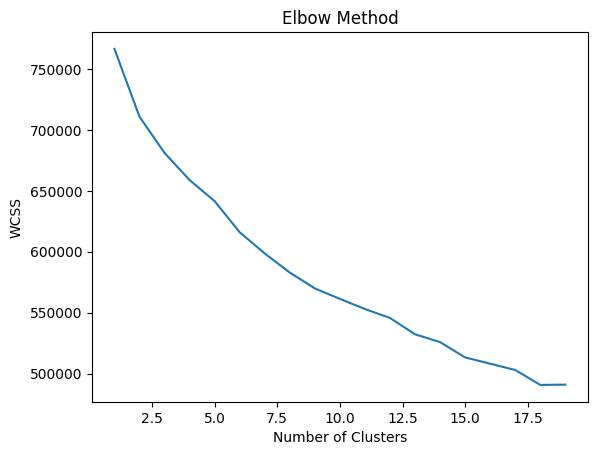

In [8]:
# Initialize list to store WCSS values
wcss = []

# Fit K-Means for a range of cluster numbers
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(result_df)
    wcss.append(kmeans.inertia_)  # inertia_ contains the WCSS value

# Plot WCSS vs. number of clusters
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

En principio, el codo estaría alrededor de 10-12.

In [9]:
n = 9
kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(result_df)

cluster_labels = kmeans.labels_
result_df['Cluster'] = cluster_labels

result_df.reset_index(inplace=True)

### Visualizando Clusters a lo largo de las temporadas y episodios

In [10]:
result_df2 = result_df[['episode_id', 'Cluster']]
result_df2 = pd.merge(result_df2, df_episode[['id', 'season', 'number_in_season']], left_on='episode_id', right_on='id')

In [11]:
#Create a pivot table with episodes and ratigns
ep_piv = result_df2.pivot_table(index='season', columns='number_in_season', values='Cluster')
ep_piv.head()

number_in_season,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
season,,,,,,,,,,,,,,,,,,,,,
1,4.0,1.0,1.0,8.0,4.0,0.0,0.0,1.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,4.0,4.0,4.0,5.0,4.0,0.0,8.0,1.0,1.0,...,2.0,4.0,5.0,4.0,4.0,4.0,2.0,NaN,NaN,NaN
3,4.0,4.0,2.0,2.0,1.0,4.0,5.0,8.0,4.0,2.0,...,8.0,8.0,4.0,4.0,1.0,2.0,8.0,4.0,1.0,NaN
4,1.0,2.0,5.0,0.0,0.0,4.0,8.0,1.0,2.0,4.0,...,1.0,5.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN
5,3.0,3.0,4.0,2.0,5.0,5.0,1.0,5.0,4.0,1.0,...,5.0,4.0,4.0,2.0,1.0,8.0,1.0,NaN,NaN,NaN


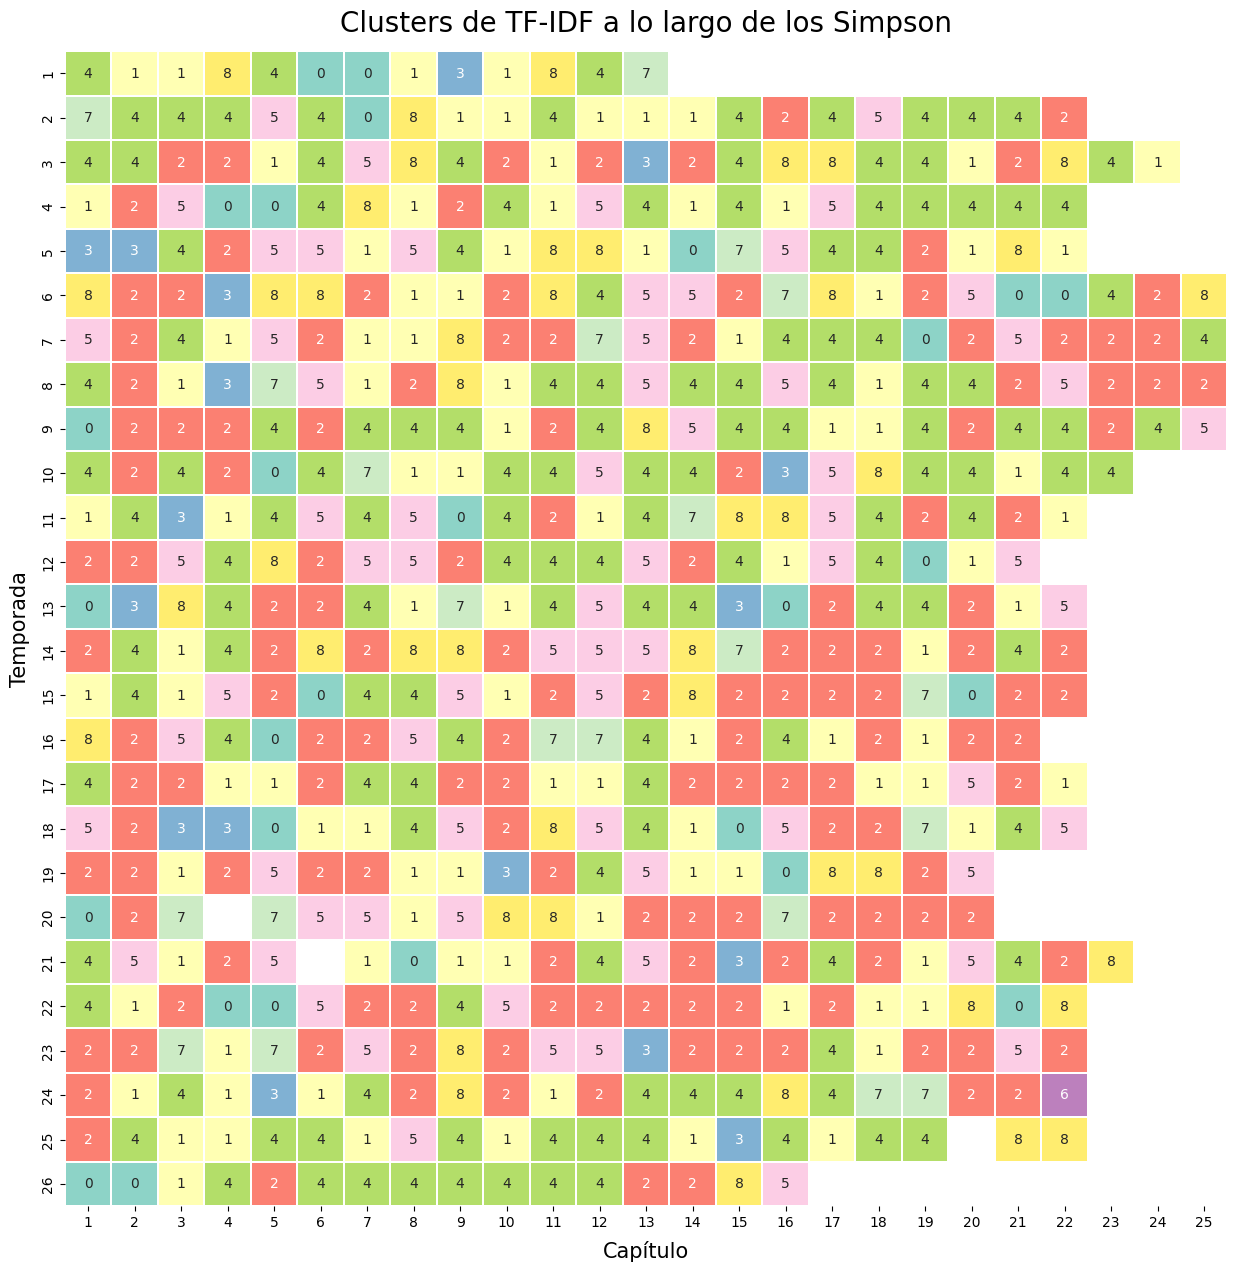

In [12]:
#Heatmap visualization
plt.figure(figsize=(15,15))
sns.heatmap(ep_piv, cmap='Set3', annot=True, linewidths=0.2,cbar_kws={'label': 'Cluster'}, cbar=False)
plt.xlabel('Capítulo', fontsize=15, labelpad=8)
plt.ylabel('Temporada', fontsize=15, labelpad=8)
plt.title('Clusters de TF-IDF a lo largo de los Simpson', fontsize=20, pad=14)
plt.show()

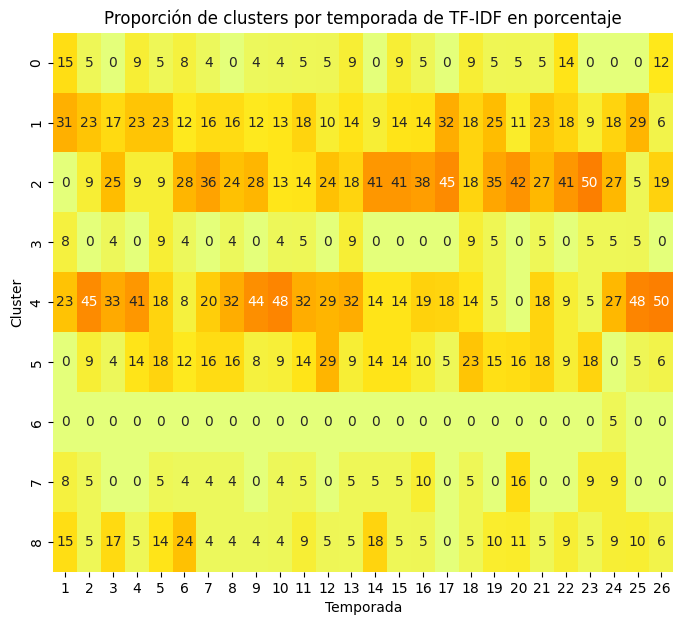

In [25]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season'])
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100

plt.figure(figsize=(8, 7))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='Wistia', fmt='.0f', cbar=False)
plt.xlabel('Temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por temporada de TF-IDF en porcentaje')
plt.show()

In [14]:
season_group_1 = range(1,11)
season_group_2 = range(11, 20)
season_group_3 = range(20, 29)

result_df2.loc[result_df2['season'].isin(season_group_1), 'season_group'] = 1
result_df2.loc[result_df2['season'].isin(season_group_2), 'season_group'] = 2
result_df2.loc[result_df2['season'].isin(season_group_3), 'season_group'] = 3
result_df2.sample(5)

,episode_id,Cluster,id,season,number_in_season,season_group
20,21.0,8,21,2,8,1.0
300,301.0,2,301,14,10,2.0
198,199.0,4,199,9,21,1.0
464,468.0,0,468,22,4,3.0
444,448.0,1,448,21,7,3.0


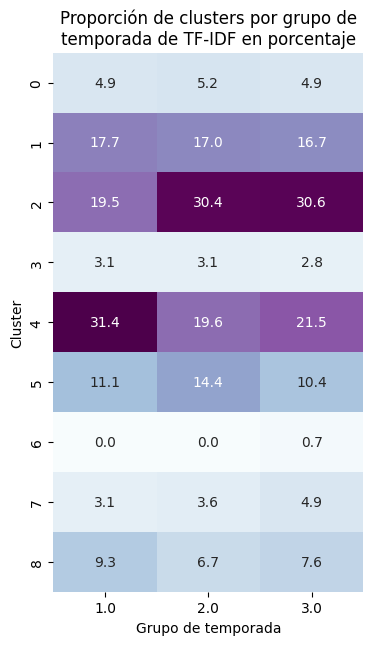

In [27]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season_group']) # Confussion matrix with absolute numbers
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100  # Multiply by 100 to get percentages, confussion matrix with relative numbers

plt.figure(figsize=(4, 7))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='BuPu', fmt='.1f', cbar=False)  # fmt='.1f' for one decimal place
plt.xlabel('Grupo de temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por grupo de\ntemporada de TF-IDF en porcentaje')

plt.show()
